<a href="https://colab.research.google.com/github/Li-Kane/CSE151A_project/blob/main/CSE151A_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
**Goal:** We want to predict how long a diabetes patient will stay in the hospital. <br/>

**Dataset Stats:** 101766 rows with 47 features and 1 target feature. <br/>

**Features Used:** race, gender, age, num_procedures, num_medications, num_diagnoses, number_emergency, diabetesMed, readmitted<br/>

**Summary:** We chose the 9 best features that we believed would best predict how long a diabetes patient will stay in the hospital and dropped unnecessary features or features that had too many missing values (such as weight and medical_specialty). Then, we cleaned up missing values, encoded our data, plotted it, split it, and validated it. <br/>

**Dataset:**
https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008 <br/>

**Citations:** <br/>
Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.

**Members:** Shijun Lun, Javier De La Cruz Zuniga, Rocky Hankin, Kane Li, Wesley Kiang, Su Aye, Asher James



In [62]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [63]:
#dependencies
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

# Data Cleaning
Extract our the features we want to use and handle NaN, Null, and other missing values

In [64]:
#load the features we want to use and target as X's and y's
features = diabetes_130_us_hospitals_for_years_1999_2008.data.features

#Since we use readmitted as a feature, which is the original targets, we have to join it to features
readmissions = diabetes_130_us_hospitals_for_years_1999_2008.data.targets
diabetes_ds = pd.concat([features, readmissions], axis=1)

#grab our relevant features
key_features = ['race', 'gender', 'age', 'num_procedures', 'num_medications', 'number_emergency', 'number_diagnoses', 'diabetesMed', 'readmitted', 'time_in_hospital']
data = diabetes_ds[key_features]

# If you want to see X or y
data.head(5)
#y.head(10)

,race,gender,age,num_procedures,num_medications,number_emergency,number_diagnoses,diabetesMed,readmitted,time_in_hospital
0,Caucasian,Female,[0-10),0,1,0,1,No,NO,1
1,Caucasian,Female,[10-20),0,18,0,9,Yes,>30,3
2,AfricanAmerican,Female,[20-30),5,13,0,6,Yes,NO,2
3,Caucasian,Male,[30-40),1,16,0,7,Yes,NO,2
4,Caucasian,Male,[40-50),0,8,0,5,Yes,NO,1


In [65]:
#see where the NaN/null values are (y has no NaN)
data.isna().sum()
#y.isna().sum()

race                2273
gender                 0
age                    0
num_procedures         0
num_medications        0
number_emergency       0
number_diagnoses       0
diabetesMed            0
readmitted             0
time_in_hospital       0
dtype: int64

In [66]:
#drop Null race values
data = data.dropna(axis=0)
data.isna().sum()

race                0
gender              0
age                 0
num_procedures      0
num_medications     0
number_emergency    0
number_diagnoses    0
diabetesMed         0
readmitted          0
time_in_hospital    0
dtype: int64

# Encoding
Race: One-hot-encoding.

Gender: Convert to binary. 1 for Male, 0 for Female.

Age: Convert to the middle of the range. Ex. 10-20 becomes 15

Diabetes_med: Convert to binary. 1 for yes, 0 for no.

Readmitted: A column for <30, and >30, and not readmitted. Direct numerical
progression, so we can do label encoding. 0, 1, 2.

In [67]:
#one-hot-encode race
race_ohe = pd.get_dummies(data['race'], prefix='race')
data = data.drop('race', axis=1)
data = pd.concat([race_ohe, data], axis=1)

In [68]:
#gender convert to binary
for index, value in data['gender'].items():
    if value == 'Male':
        data.at[index, 'gender'] = 1
    elif value == 'Female':
        data.at[index, 'gender'] = 0

In [69]:
#age convert to middle of range
for index, value in data['age'].items():
    lower, higher = value.split('-')
    lower = int(lower[1:])
    higher = int(higher[:-1])
    middle = (lower + higher) // 2
    data.at[index, 'age'] = middle

In [70]:
#diabetes med convert to binary
for index, value in data['diabetesMed'].items():
    if value == 'No':
        data.at[index, 'diabetesMed'] = int(0)
    elif value == 'Yes':
        data.at[index, 'diabetesMed'] = int(1)

In [71]:
#label encode readmitted
for index, value in data['readmitted'].items():
    if value == 'NO':
        data.at[index, 'readmitted'] = int(2)
    elif value == '>30':
        data.at[index, 'readmitted'] = int(1)
    elif value == '<30':
        data.at[index, 'readmitted'] = int(0)

In [72]:
#Verify encoding
data.head(5)

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender,age,num_procedures,num_medications,number_emergency,number_diagnoses,diabetesMed,readmitted,time_in_hospital
0,0,0,1,0,0,0,5,0,1,0,1,0,2,1
1,0,0,1,0,0,0,15,0,18,0,9,1,1,3
2,1,0,0,0,0,0,25,5,13,0,6,1,2,2
3,0,0,1,0,0,1,35,1,16,0,7,1,2,2
4,0,0,1,0,0,1,45,0,8,0,5,1,2,1


Encode gender since it has strings that say "Unknown/Invalid"

In [73]:
# Find column elements that are neither 0 nor 1
data['gender'].unique()

array([0, 1, 'Unknown/Invalid'], dtype=object)

In [74]:
# Drop rows that contain extraneous element & convert column to numerical
filter = data['gender'] == 'Unknown/Invalid'
data = data[~filter]
data['gender'] = pd.to_numeric(data['gender'])

# verify
print(data['gender'].unique())

[0 1]


<ipython-input-74-63610352523c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gender'] = pd.to_numeric(data['gender'])


# Normalize and Standardize Data
To improve training stability and performance, we use MinMaxScaling to normalize age, num_procedures, num_medications, number__emergency, and number_diagnoses. Then, we use StandardScaler to standardize all the data to a normal distribution.

In [75]:
#normalize input data
from sklearn.preprocessing import minmax_scale

#Only normalize cols whose values vary a lot
scaleCols = ['age', 'num_procedures', 'num_medications', 'number_emergency', 'number_diagnoses']
data[scaleCols] = minmax_scale(data[scaleCols])

<ipython-input-75-d7bcb5094ce6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[scaleCols] = minmax_scale(data[scaleCols])


In [76]:
#standardize the relevant columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[scaleCols])
data[scaleCols] = scaler.transform(data[scaleCols])

<ipython-input-76-101abcde9214>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[scaleCols] = scaler.transform(data[scaleCols])


In [77]:
#verify
print(data.mean())
print(data.std())

race_AfricanAmerican    1.930809e-01
race_Asian              6.442729e-03
race_Caucasian          7.648756e-01
race_Hispanic           2.047401e-02
race_Other              1.512684e-02
gender                  4.615145e-01
age                     6.136155e-16
num_procedures          5.113462e-17
num_medications        -2.912388e-16
number_emergency        4.285024e-19
number_diagnoses        4.970628e-16
diabetesMed             7.688156e-01
readmitted              1.423622e+00
time_in_hospital        4.398454e+00
dtype: float64
race_AfricanAmerican    0.394718
race_Asian              0.080008
race_Caucasian          0.424079
race_Hispanic           0.141616
race_Other              0.122058
gender                  0.498519
age                     1.000005
num_procedures          1.000005
num_medications         1.000005
number_emergency        1.000005
number_diagnoses        1.000005
diabetesMed             0.421592
readmitted              0.684611
time_in_hospital        2.986972
dtype

# Visualization

<Axes: >

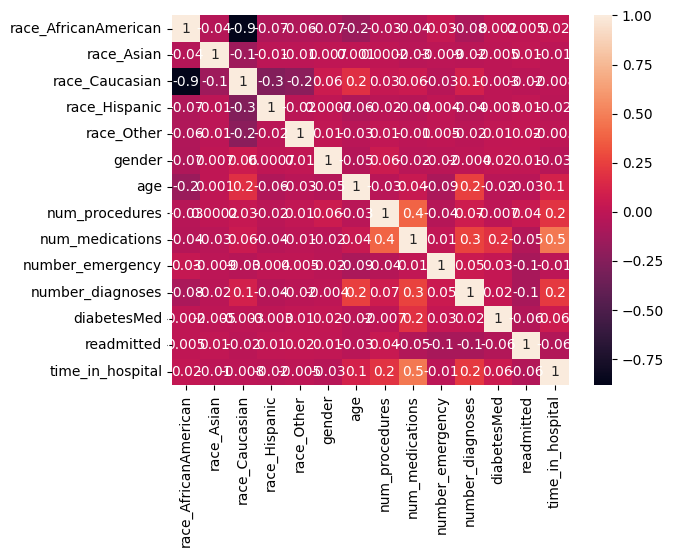

In [78]:
# visualizing data via correlation matrix (heatmap) and pair plot
# make sure everything's numerical
data = data.convert_dtypes(convert_string=False)

#we'll include our target data in our plot
sns.heatmap(data.corr(), fmt = '.1g', annot = True, cbar=True)

Observations from the heatmap:

1.   Most features aren't very correlated with each other
2.   The correlation between racial categories varies even though they're equally mutually exclusive
3.   By far the feature most correlated with the duration of the hospital stay is how many medications they're on.
4.   When we build our model to predict time in hospital, we should drop race, number of emergencies, readmission, and whether they're on medication as these have low correlation with the target.

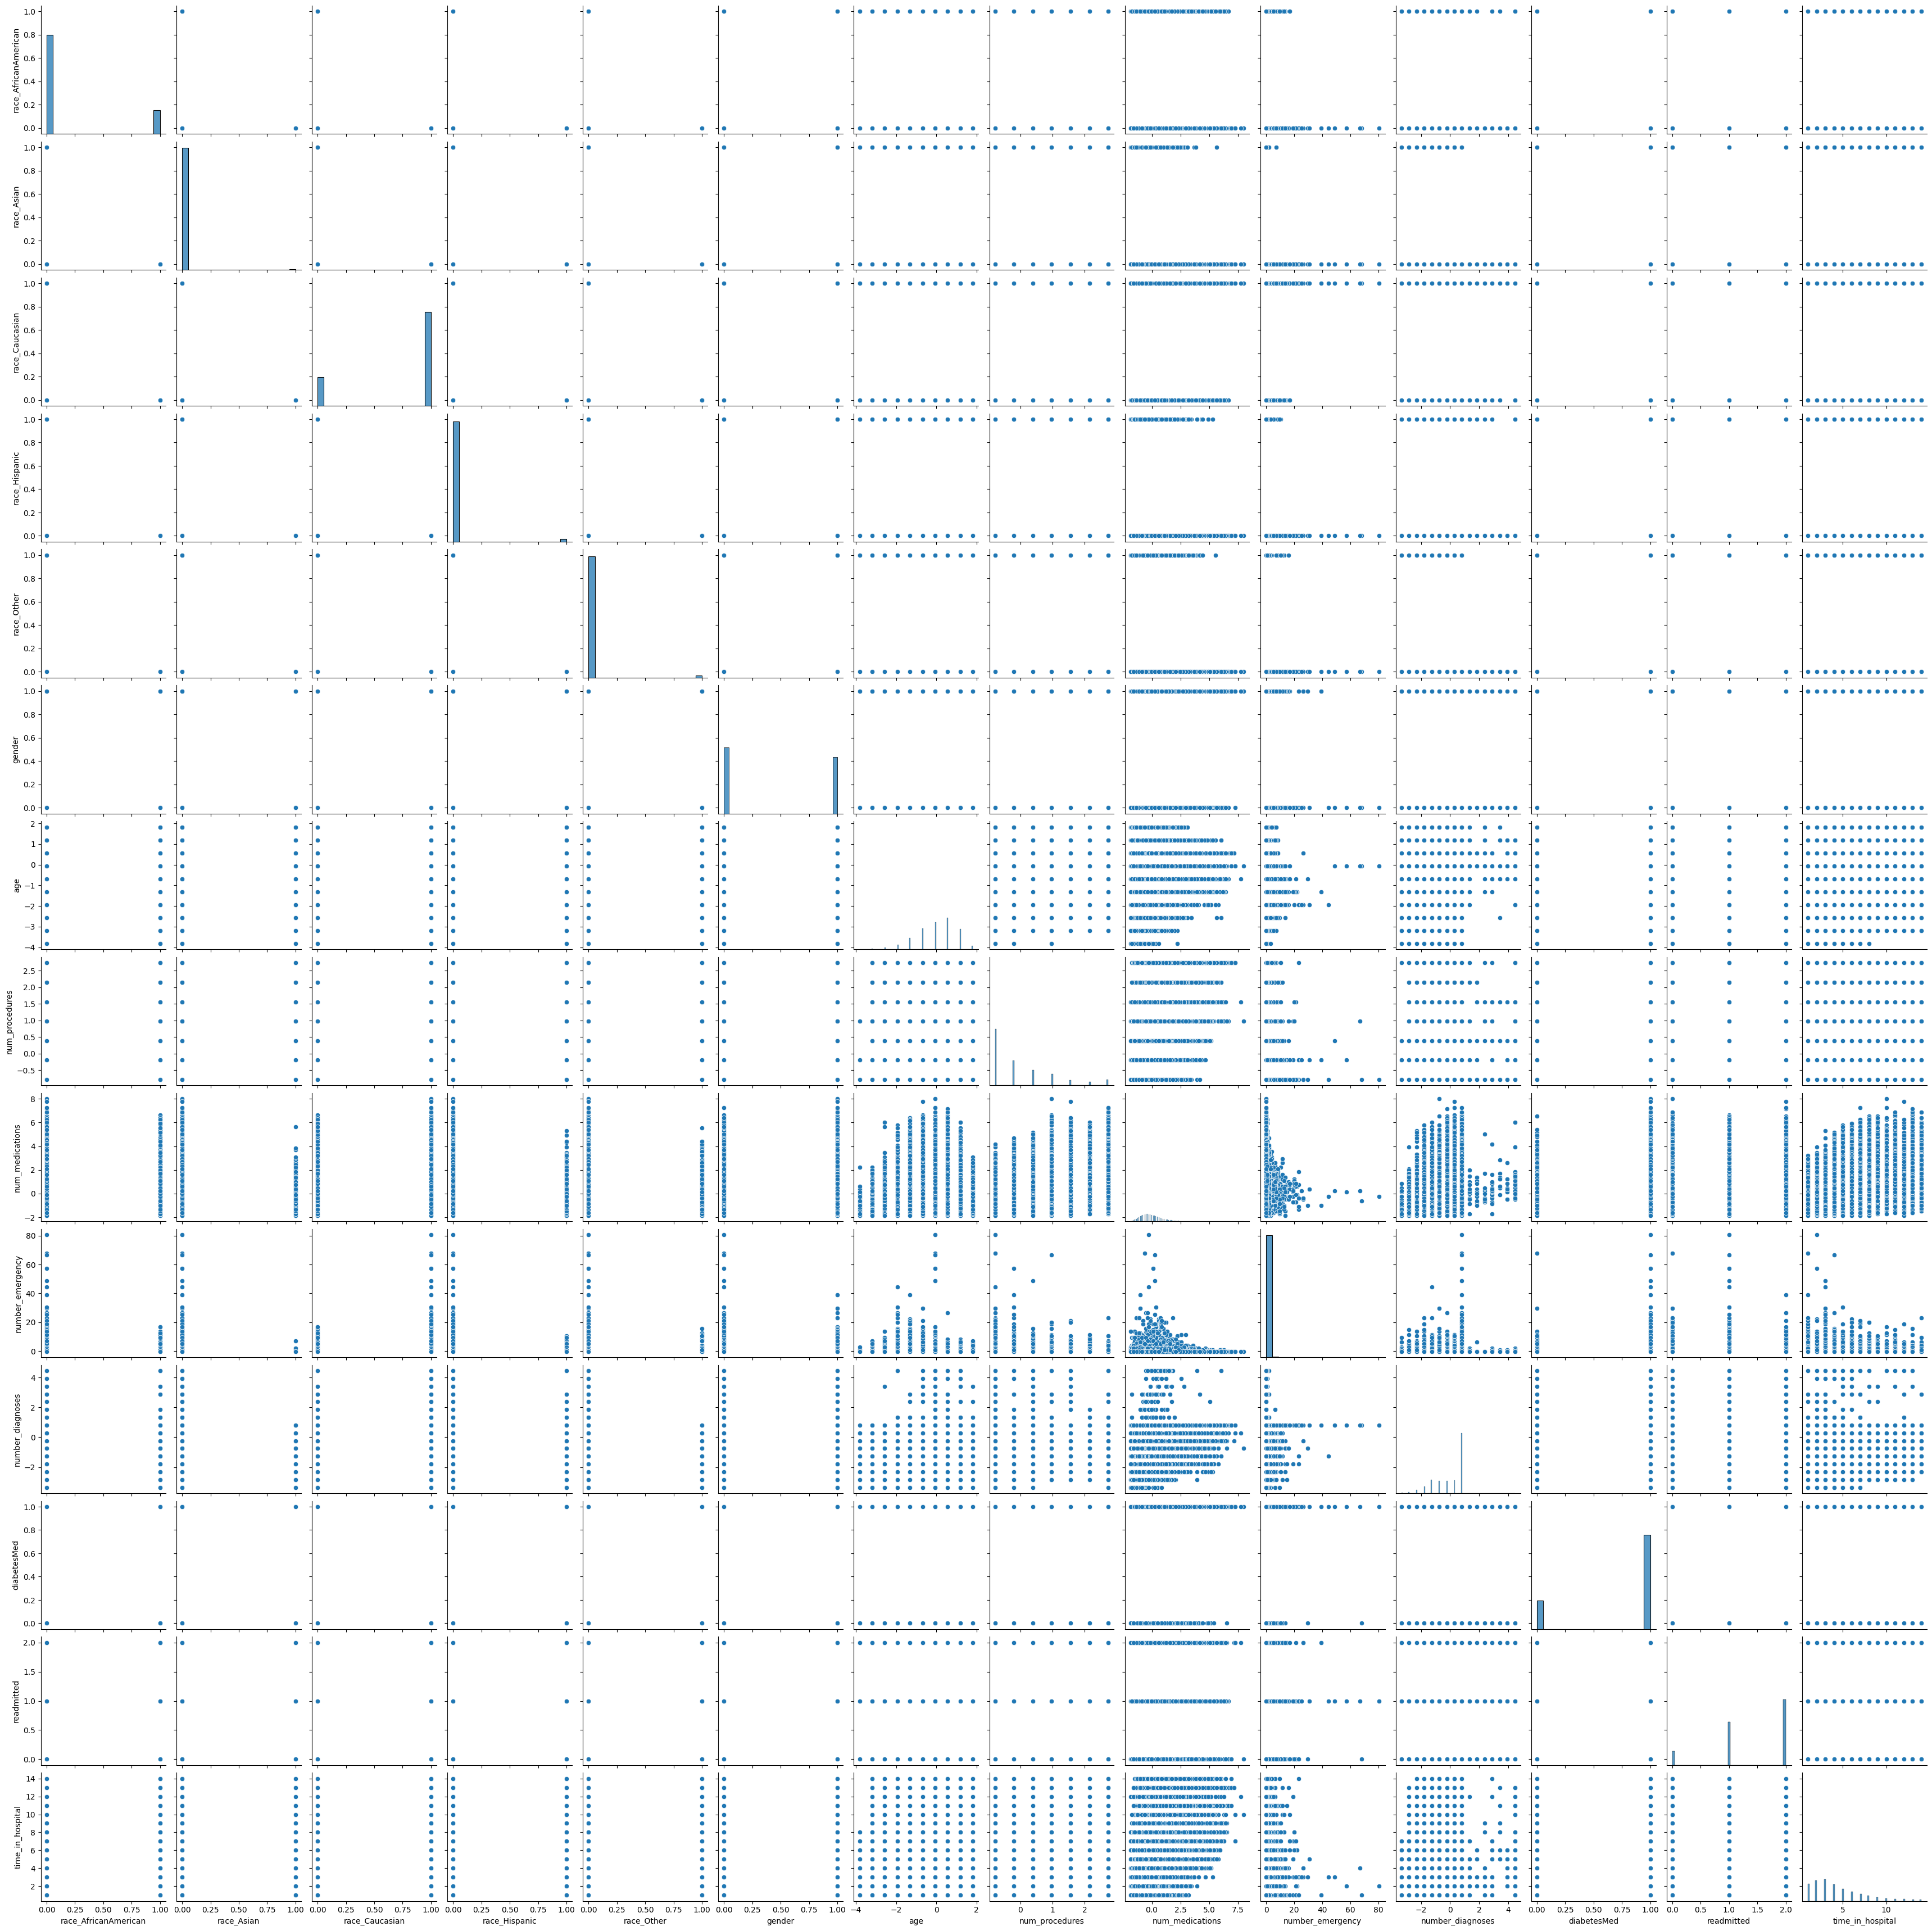

In [79]:
sns.pairplot(data)

Observations from the pair plot

1.   Although they didn't show high correlation in the heatmap, num emergencies and num medications show a fairly distinct shape on their scatter plot. We can see everyone with a high number of emergencies wasn't on that much medication, but maybe this is a function of sample size.
2.   Num medications and age also have a distinct graph shape despite having low correlation on our heatmap.
3.   Number procedures vs. time in hospital is so perfectly square shaped its actually strikes me as odd
4.   Our data points for number of procedures are skewed heavily towards the highest value in range, that being 6.
5.   Caucasians are vastly over represented in the data set. They outnumber the other races combined by at least 3 to 1.

In [80]:
# shuffle data and split train test with seed
from sklearn.model_selection import train_test_split

y = data['time_in_hospital']
X = data.drop(['time_in_hospital'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

#verify
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(79593, 13)
(79593,)
(19899, 13)


# Data Verification

Ensure our data follows the expected distributions and values.

### Datatype validation

race_AfricanAmerican
ShapiroResult(statistic=0.48200178146362305, pvalue=0.0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


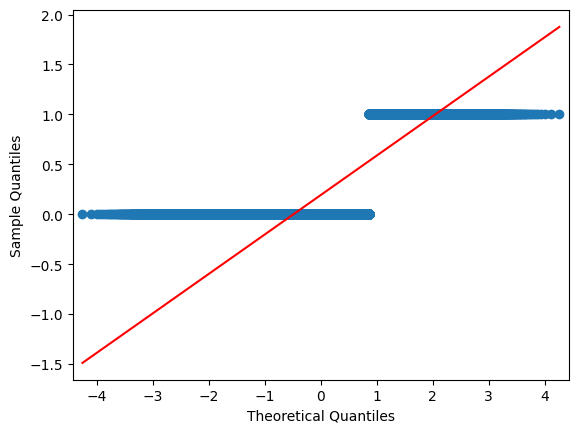

race_Asian
ShapiroResult(statistic=0.05123013257980347, pvalue=0.0)


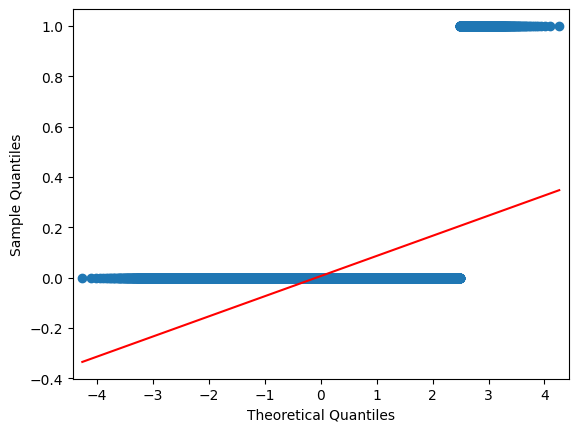

race_Caucasian
ShapiroResult(statistic=0.5253992080688477, pvalue=0.0)


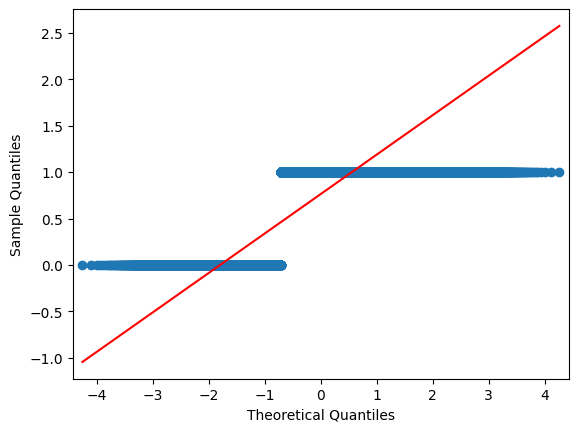

race_Hispanic
ShapiroResult(statistic=0.12162750959396362, pvalue=0.0)


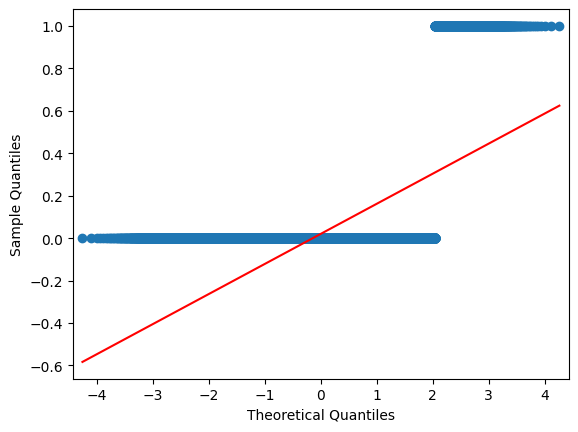

race_Other
ShapiroResult(statistic=0.09766680002212524, pvalue=0.0)


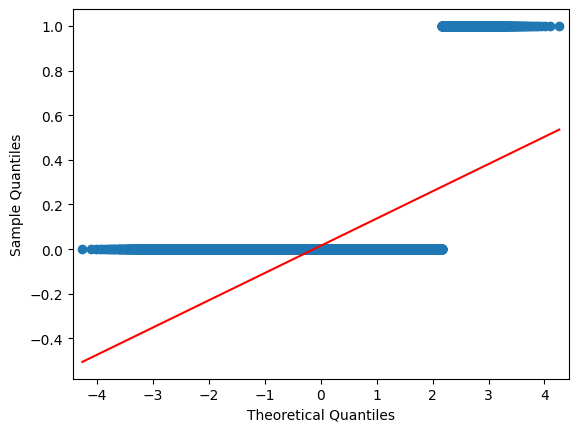

gender
ShapiroResult(statistic=0.6352283358573914, pvalue=0.0)


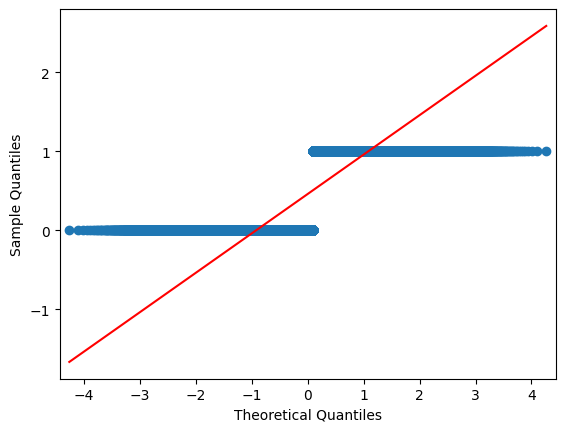

age
ShapiroResult(statistic=0.9394146800041199, pvalue=0.0)


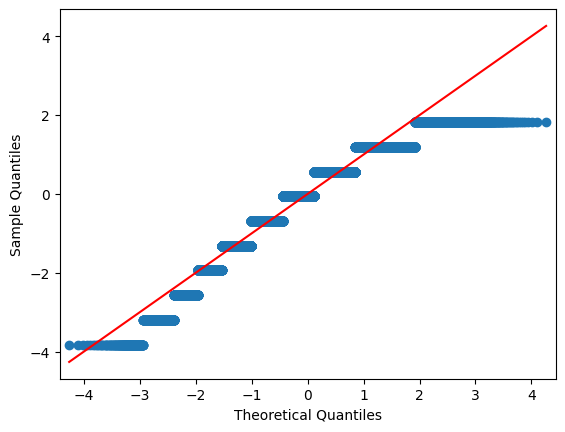

num_procedures
ShapiroResult(statistic=0.775197446346283, pvalue=0.0)


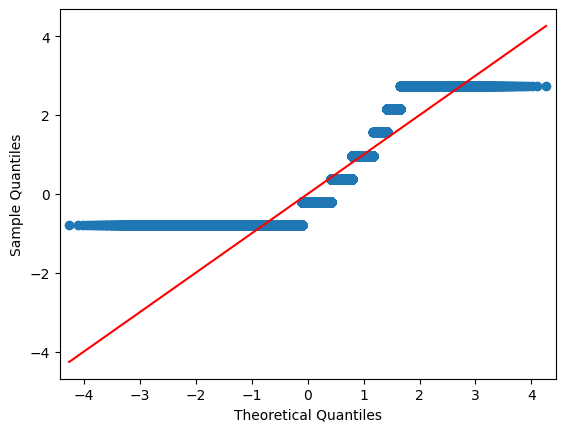

num_medications
ShapiroResult(statistic=0.9248141646385193, pvalue=0.0)


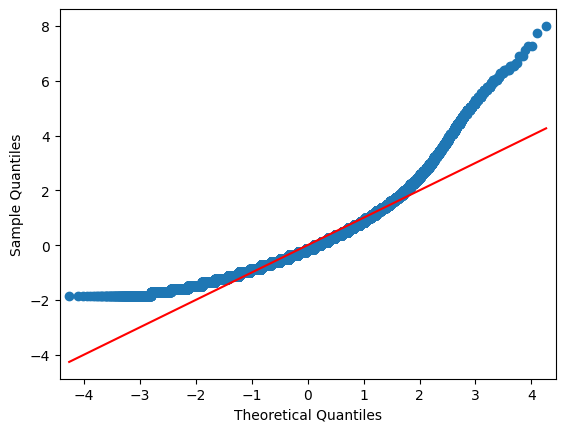

number_emergency
ShapiroResult(statistic=0.19951218366622925, pvalue=0.0)


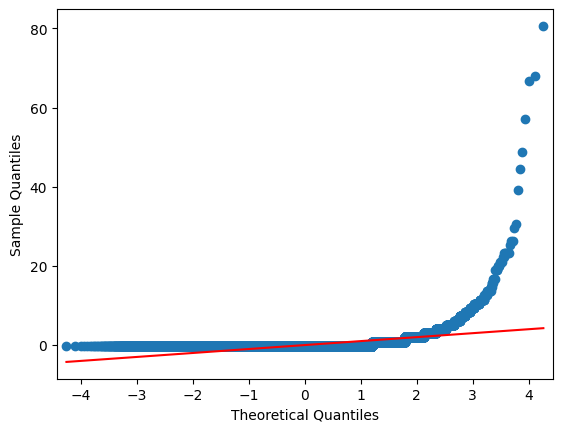

number_diagnoses
ShapiroResult(statistic=0.8009593486785889, pvalue=0.0)


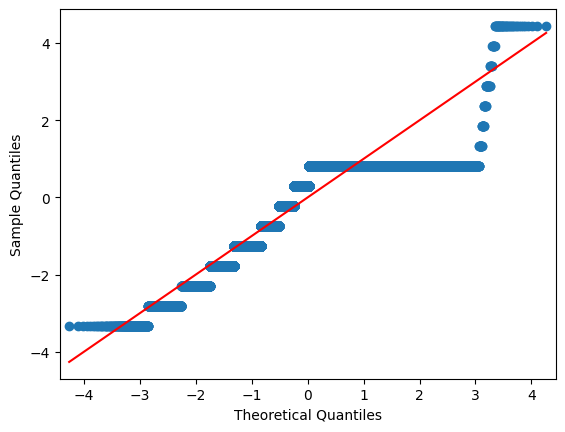

diabetesMed
ShapiroResult(statistic=0.5218844413757324, pvalue=0.0)


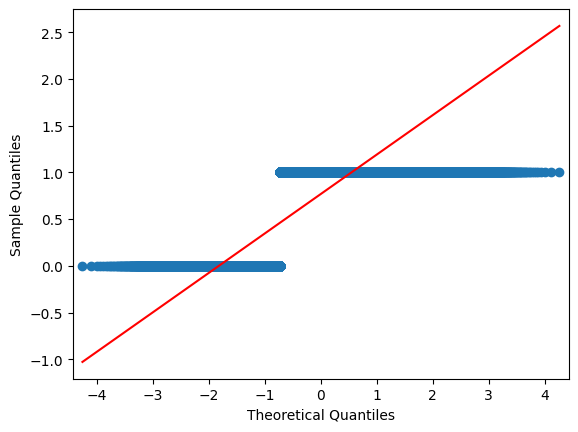

readmitted
ShapiroResult(statistic=0.7380174994468689, pvalue=0.0)


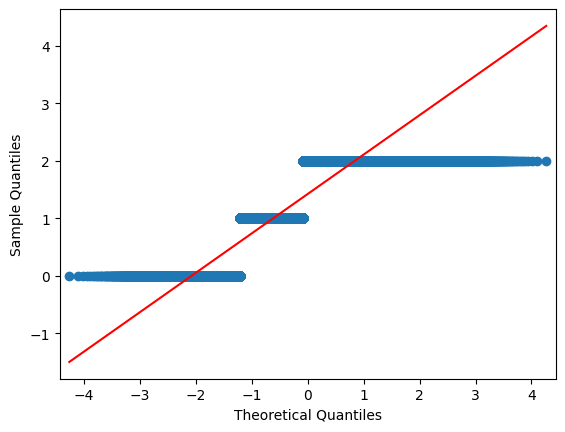

time_in_hospital
ShapiroResult(statistic=0.8868542909622192, pvalue=0.0)


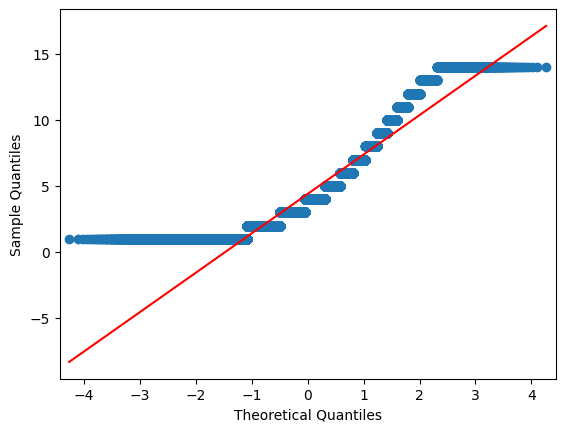

In [81]:
# Use QQ-plot & Shapiro-Wilkes test for normality
for col in data.columns:
    print(col)
    print(shapiro(data[col]))
    qqplot(data[col], line='s')
    plt.show()


While it is expected that labels such as gender and race aren't normally distributed, we see from the QQ plots & the resulting p-values that our normalized and standardized columns do not follow the normal distribution very well, indicating that we may need to revisit our methods of normalizatiion & standardization. However, they do roughly follow a normal distribution.

# Milestone 3: Training our First Model

**Model Evaluation**  
Since we are attempting to predict days in hospital, which is an int, we decided to start with linear regression. When we evaluated our model's performance, even though the Train and Test were relatively the same, the model accuracy wasn't very good. To see if this was overfitting or underfitting, we tried using polynomial regression and saw that even though a degree of 2 is marginally better, the results are much the same. Therefore, it can be concluded that the current structure and data aren't well suited to the task. For future improvements, we can try to expand our dataset (such as readd dropped columns), or perhaps use bagging, where we build models of different polynomial degrees or data and take the mean of their predictions.

**Future Models**  
The first future model we plan on trying is to use a classic ANN/DNN since the output only ranges between 1-14 (14 classes), which is relatively narrow. Doing so will allow us to make our model much more complex with many more different combinations of layer sizes, depth, activation functions, and more.  
Our second future model plan is to use another regression model, likely polynomial or ridge regression. Even though we used polynomial regression to test how our linear regressor was working, there is much to expand upon with an improved dataset. However, since it is very similar to linear regression and what we have done so far, we may also try another form of regression such as ridge or lasso.

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#basic linear regression
reg = LinearRegression()
regmodel = reg.fit(X_train, y_train)
yhat_train = reg.predict(X_train)
yhat_test = reg.predict(X_test)

In [83]:
#Evalute our train vs test error for the linear model
print("Train MSE: ", mean_squared_error(y_train, yhat_train))
print("Train Standard Deviation: ", np.std(y_train - yhat_train))
print("Test MSE: ", mean_squared_error(y_test, yhat_test))
print("Test Standard Deviation: ", np.std(y_test - yhat_test))

Train MSE:  6.813194031011412
Train Standard Deviation:  2.6102095759205106
Test MSE:  6.759481197263411
Test Standard Deviation:  2.59989951904394


In [84]:
from sklearn.preprocessing import PolynomialFeatures
#can expanding features with Polynomials help?
trainMSE = []
testMSE = []
deg = [0, 1, 2, 3, 4]
for deg in range(5):
  poly_features = PolynomialFeatures(degree=deg)
  X_train_poly = poly_features.fit_transform(X_train)
  X_test_poly = poly_features.fit_transform(X_test)
  reg = LinearRegression()
  regmodel = reg.fit(X_train_poly, y_train)
  yhat_train = reg.predict(X_train_poly)
  yhat_test = reg.predict(X_test_poly)
  train_MSE = mean_squared_error(y_train, yhat_train)
  trainMSE.append(train_MSE)
  test_MSE = mean_squared_error(y_test, yhat_test)
  testMSE.append(test_MSE)
  print("Degree: ", deg)
  print("Train MSE: ", train_MSE)
  print("Test MSE: ", test_MSE)

Degree:  0
Train MSE:  8.925794495723292
Test MSE:  8.906393860761339
Degree:  1
Train MSE:  6.813329926491826
Test MSE:  6.759093339002649
Degree:  2
Train MSE:  6.619261370004652
Test MSE:  6.5568623285037875
Degree:  3
Train MSE:  6.537754012184603
Test MSE:  6.563053350348246
Degree:  4
Train MSE:  6.450946593071605
Test MSE:  19060328.207478154


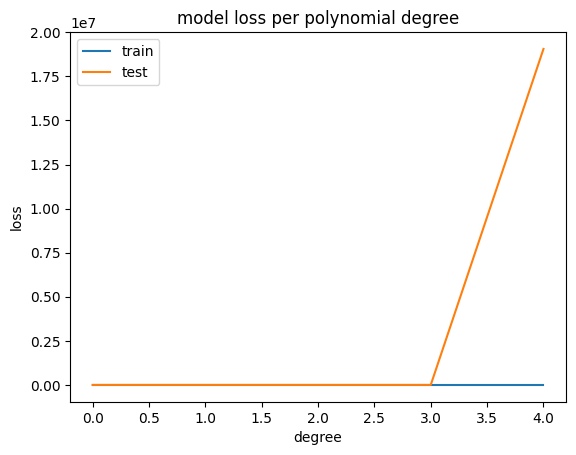

In [85]:
# plot
plt.plot(trainMSE)
plt.plot(testMSE)
plt.title('model loss per polynomial degree')
plt.ylabel('loss')
plt.xlabel('degree')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Milestone 4: Second Model

Classic neural networks using classification and categorical cross entropy. Classification reaches up to 22% and regression MSE 6.6, approximately the same as for our linear and polynomial regression models.


In [86]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [116]:
ytr_ohe = pd.get_dummies(y_train)
ytes_ohe = pd.get_dummies(y_test)
print(ytr_ohe)

       1   2   3   4   5   6   7   8   9   10  11  12  13  14
22820   0   1   0   0   0   0   0   0   0   0   0   0   0   0
10220   0   0   1   0   0   0   0   0   0   0   0   0   0   0
28688   0   1   0   0   0   0   0   0   0   0   0   0   0   0
91212   0   1   0   0   0   0   0   0   0   0   0   0   0   0
2140    0   0   0   1   0   0   0   0   0   0   0   0   0   0
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
83724   0   0   0   0   1   0   0   0   0   0   0   0   0   0
9134    0   0   0   0   0   0   0   0   0   0   0   1   0   0
72882   1   0   0   0   0   0   0   0   0   0   0   0   0   0
72248   0   0   1   0   0   0   0   0   0   0   0   0   0   0
82558   0   0   0   1   0   0   0   0   0   0   0   0   0   0

[79593 rows x 14 columns]


In [ ]:
model = Sequential();

model.add(keras.Input(shape=(13,)))
model.add(Dense(40, activation="relu"))
model.add(Dense(40, activation="relu"))
model.add(Dense(40, activation="relu"))
model.add(Dense(14, activation="sigmoid"))

optimizer = SGD(learning_rate=0.1)
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train.astype(float), ytr_ohe, epochs=30, validation_split=0.2, batch_size=50, verbose=1)

In [118]:
predictions = model.evaluate(X_test.astype(float), ytes_ohe)
print("test accuracy: ", predictions[1])

622/622 [==============================] - 2s 3ms/step - loss: 2.1354 - acc: 0.2136
test accuracy:  0.21357856690883636


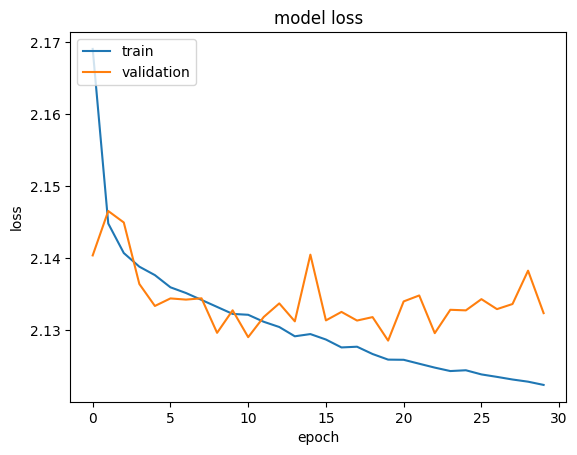

In [91]:
# plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

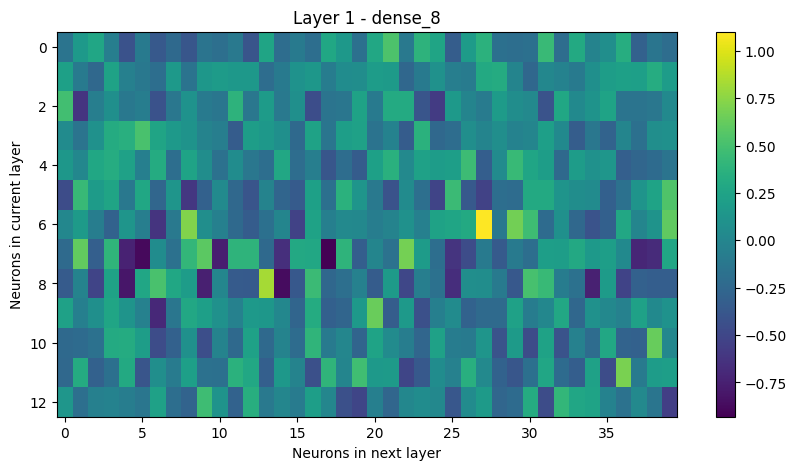

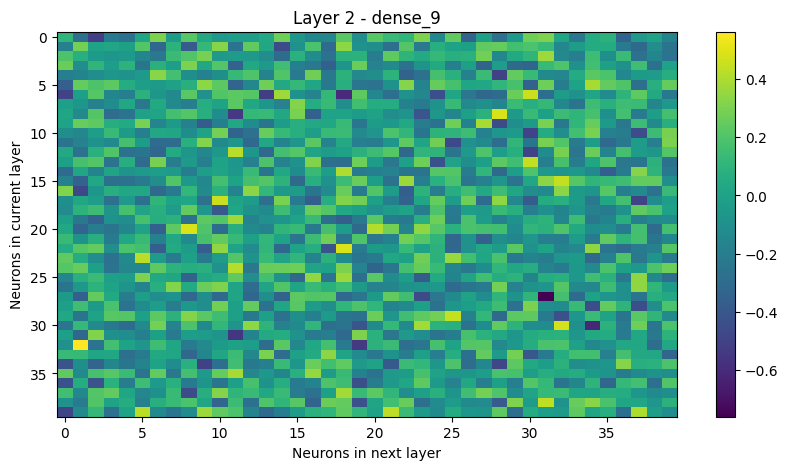

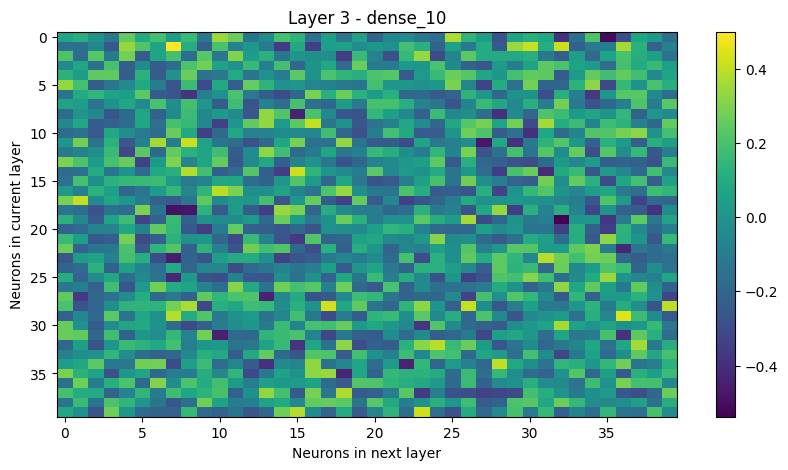

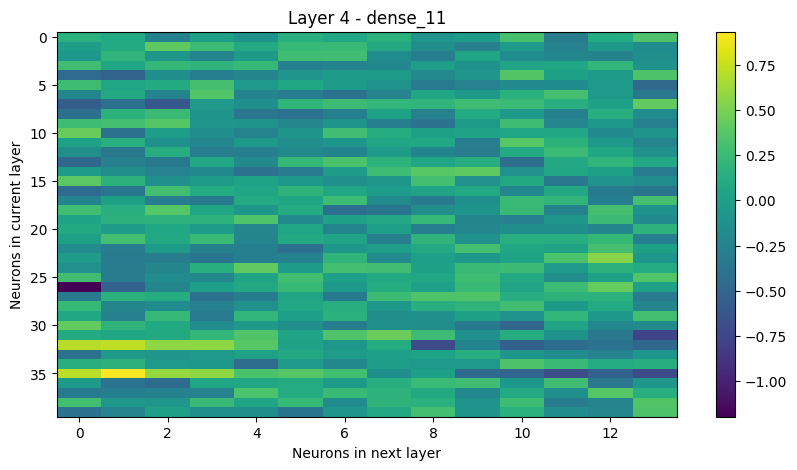

In [92]:
# visualize our weights
import matplotlib.pyplot as plt

# Assuming 'model5' is your trained model
for i, layer in enumerate(model.layers):
    weights, bias = layer.get_weights()

    plt.figure(figsize=(10, 5))
    plt.imshow(weights, aspect='auto', cmap='viridis')  # 'viridis' is just one of many colormaps
    plt.colorbar()
    plt.title(f'Layer {i+1} - {layer.name}')
    plt.xlabel('Neurons in next layer')
    plt.ylabel('Neurons in current layer')
    plt.show()

In [94]:
model7 = Sequential();

model7.add(keras.Input(shape=(13,)))
model7.add(Dense(40, activation="relu"))
model7.add(Dense(40, activation="relu"))
model7.add(Dense(40, activation="relu"))
model7.add(Dense(14, activation="softmax"))

optimizer = SGD(learning_rate=0.1)
model7.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['acc'])
history7 = model7.fit(X_train.astype(float), ytr_ohe, epochs=20, batch_size=50, verbose=0)

In [106]:
# we can get approximate MSE from our softmax since it is probabilities
# so we multiply probabilities by days and sum
pred6 = model7.predict(X_test.astype('float'))
w = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
pred_day = pred6 @ w
mean_error = np.mean(np.absolute(y_test  - pred_day))
mse = np.mean(np.square(y_test  - pred_day))
print("mse: ", mse)

622/622 [==============================] - 1s 2ms/step
mse:  6.528266924907395


<Axes: xlabel='error', ylabel='index in y_test'>

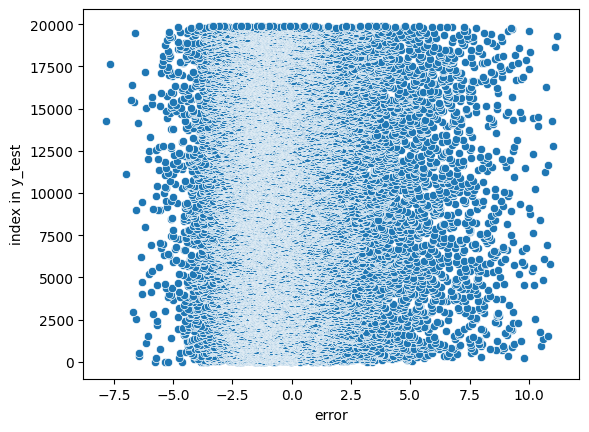

In [96]:
# visualize our errors
y_vals = np.linspace(0, y_test.shape[0], y_test.shape[0])
error = y_test  - pred_day
graphDF = {'error': error, 'index in y_test': y_vals}
sns.scatterplot(graphDF, x='error', y='index in y_test')

#Final Model

#### Decision Tree Classifier

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [40]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Decision Tree Classifier stats")
print(f"mse: {mse}")
print(classification_report(y_test, y_pred))

Decision Tree Classifier stats
mse: 11.694959545705814
              precision    recall  f1-score   support

         1.0       0.24      0.31      0.27      2791
         2.0       0.21      0.26      0.23      3378
         3.0       0.18      0.22      0.20      3424
         4.0       0.15      0.15      0.15      2686
         5.0       0.12      0.09      0.10      1957
         6.0       0.09      0.06      0.07      1560
         7.0       0.07      0.05      0.06      1144
         8.0       0.05      0.03      0.04       858
         9.0       0.06      0.04      0.05       565
        10.0       0.06      0.04      0.05       448
        11.0       0.06      0.04      0.05       363
        12.0       0.02      0.01      0.02       271
        13.0       0.05      0.03      0.04       247
        14.0       0.04      0.02      0.03       207

    accuracy                           0.17     19899
   macro avg       0.10      0.10      0.10     19899
weighted avg       0.15  

In [41]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

vals = classification_report(y_test, y_pred, output_dict=True)

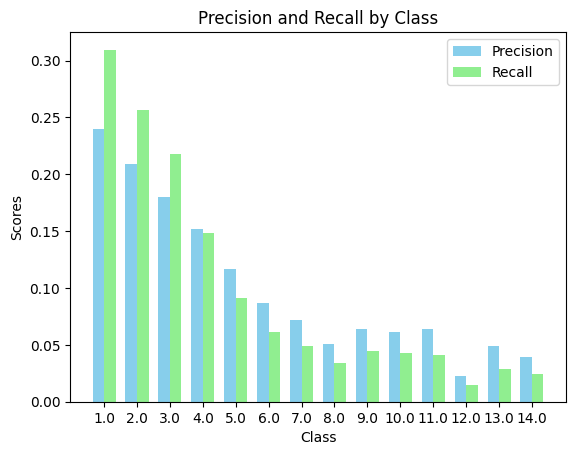

In [42]:
# Extracting classes, precision, and recall
classes = list(vals.keys())[:-3]  # Excluding the last three keys which are not classes
precision = [vals[cls]['precision'] for cls in classes]
recall = [vals[cls]['recall'] for cls in classes]

# Setting up the x-axis for the classes
x = np.arange(len(classes))

# Plotting
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision, width, label='Precision', color='skyblue')
rects2 = ax.bar(x + width/2, recall, width, label='Recall', color='lightgreen')

# Adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Precision and Recall by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
plt.show()

#### Decision Tree Regressor

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor


tree_reg = DecisionTreeRegressor()
param_grid = {
    'max_depth': [None, 3, 6, 9, 12,15,18,21],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gridsearch = GridSearchCV(tree_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)

gridsearch.fit(X_train,y_train)
print(f"Best params: {gridsearch.best_params_}")
y_pred = gridsearch.predict(X_train)
tree_reg_training_err = np.mean(np.square(y_pred - y_train))
print(f"Mean Squared Training Error Decision Tree Regressor: {tree_reg_training_err}")

Best params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10}
Mean Squared Training Error Decision Tree Regressor: 6.701541349151196


In [44]:
best_model = gridsearch.best_estimator_
tree_reg_test_pred = best_model.predict(X_test)
tree_reg_test_err = np.mean(np.square(tree_reg_test_pred - y_test))
print(f"Mean Squared Test Error of Decision Tree Regressor: {tree_reg_test_err}")

Mean Squared Test Error of Decision Tree Regressor: 6.711323110010316
